<a href="https://colab.research.google.com/github/Madhumita1110/My_Projects/blob/main/Stress_Prediction_LSTM%26CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torch

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Import and Exploratory analysis

Import HumanStressDetection dataset from Kaggle on a pandas dataframe using pandas library

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Deep Learning/Stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [ ]:
##check for null values

df.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

<Axes: title={'center': 'Distribution of label'}, xlabel='Labels', ylabel='Counts'>

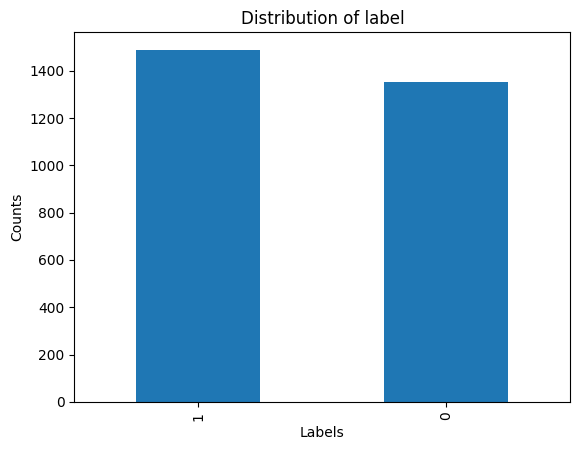

In [ ]:
###check the distribution of labels, doesn't look to be class imbalanced.

import matplotlib.pyplot as plt

dist= df['label'].value_counts()

dist.plot(x='label',
        kind='bar',
        stacked= False,
        title='Distribution of label',
        xlabel= 'Labels',
        ylabel= 'Counts')

In [ ]:
##count the respective counts of subreddit posts contributing to stress prediction dataset

df.subreddit.value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

<Axes: ylabel='subreddit'>

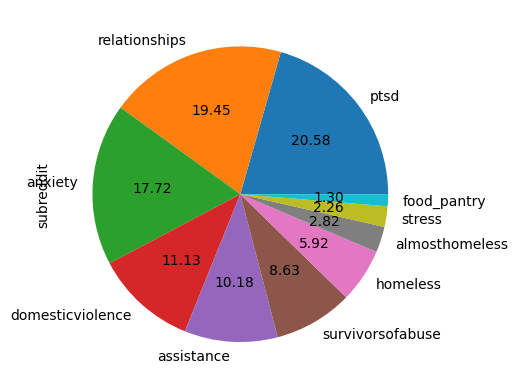

In [ ]:
##view on a pie chart

df['subreddit'].value_counts().plot(kind= "pie", autopct='%.2f')

The highest posts related to stress are frpm PTSD (Post-traumatic stress disorders) followed by relationships and anxiety.

<Axes: title={'center': 'Subreddit wise stress count'}, xlabel='subreddit'>

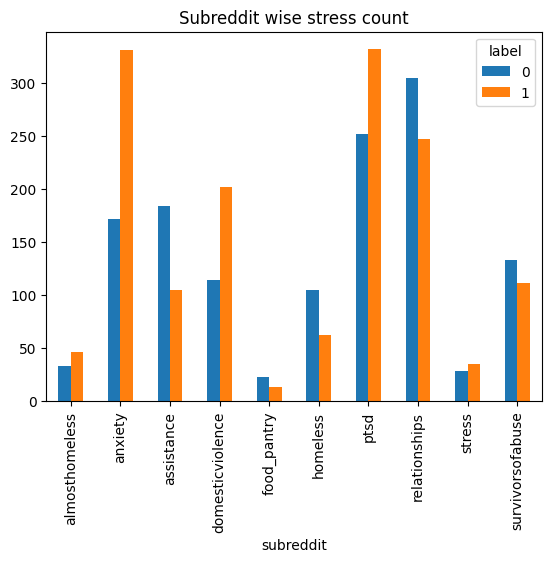

In [ ]:
###subredditwise stress count using a bar plot

pd.crosstab(df['subreddit'], df['label']).plot(kind='bar', stacked=False, title='Subreddit wise stress count')

When we count stress related posts by subreddits,we found that anxiety and ptsd have most cases followed by relationships.

In [ ]:
##delete absolutely unwanted columns

del df['post_id']
del df['sentence_range']

In [ ]:
df.head()

,subreddit,text,label,confidence,social_timestamp
0,ptsd,"He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,0.8,1539809005


# Text Preprocessing

In [ ]:
df['text'].values

array(['He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.',
       "Hey there r/assistance, Not sure if this is the right place to post this.. but here goes =) I'm currently a student intern at Sandia National Labs and working on a survey to help improve our marketing outreach efforts at the many schools we recruit at around the country. We're looking for current undergrad/grad STEM students so if you're a STEM student or know STEM students, I would greatly appreciate if 

Import necessary libraries for text cleaning and preprocessing.

In [ ]:
import re,string,unicodedata

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#defining function for preprocessing

def preprocess(text):
    if isinstance(text,str):
      text = re.sub('\W+',' ', text)                                        #for replacing non-word characters
      text = re.sub('\s+',' ', text)                                        #for replacng extra spaces
      #text = re.sub("(?<!\w)\d+", "", text)                                 # Remove all numbers except those attached to a word
      text = re.sub("-(?!\w)|(?<!\w)-", "", text)                           # Remove all hyphens except between two words
      text=text.lower() if isinstance(text,str) else text

      nopunc=[char for char in text if char not in string.punctuation]      #for removing punctuation in the strings
      nopunc=''.join(nopunc)

      nopunc=' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])   #for removing stop words
      return nopunc
      
    else:
      return ''



In [ ]:
##call function preprocess

df['text']=df['text'].apply(preprocess)

In [ ]:
##now let's check the preprocessed and cleaned text

df['text'].values

array(['said felt way suggeted go rest trigger ahead youi hypocondriac like decide look feelings doom hopes maybe getting sucked rabbit hole ludicrous conspiracy stupid psychic test new age b something could even laugh road ended reading sense doom indicative various health ailments one prone top doom gloom f n worried heart happen physical 48 hours',
       'hey r assistance sure right place post goes currently student intern sandia national labs working survey help improve marketing outreach efforts many schools recruit around country looking current undergrad grad stem students stem student know stem students would greatly appreciate help take pass along short survey thank everyone helps take survey entered drawing chance win one three 50 amazon gcs',
       'mom hit newspaper shocked would knows like play hitting smacking striking hitting violence sort person send vibe asking universe yesterday decided take friend go help another friend move new place driving friend moving strikes 

See that all required cleaning has been done, and stopwords are also removed.

**Lemmatization**

Now, import pre-trained English language pipeline 'en_core_web_sm' from SpaCy library for lemmatization of words. It is trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities.Lemmatization is the process of grouping together different inflected forms of the same word. For eg., change, changes, changing, changed are derived from the word 'change', so they would be grouped together as a lemma. Lemmatization is preferred where the context of the text is important where as we can use stemming when the context of the text is not important. SpaCy lemmatizers are better than NLTK because it uses the latest and the best algorithms.

In [ ]:
import spacy
nlp=spacy.load('en_core_web_sm')

In [ ]:
# lemmatization
def lemmatize(words):
   
    words=nlp(words)
    lemmas = []
    for word in words:
        
        lemmas.append(word.lemma_)
    return lemmas
#converting them into string
def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    
    lemmas=lemmatize(input)
    return listtostring(lemmas)

In [ ]:
#Apply function on text column
df['text']=df['text'].apply(clean_text)

In [ ]:
df['text'].values

array(['say feel way suggete go rest trigger ahead youi hypocondriac like decide look feeling doom hope maybe getting suck rabbit hole ludicrous conspiracy stupid psychic test new age b something could even laugh road end read sense doom indicative various health ailment one prone top doom gloom f n worried heart happen physical 48 hour',
       'hey r assistance sure right place post go currently student intern sandia national labs work survey help improve marketing outreach effort many school recruit around country look current undergrad grad stem student stem student know stem student would greatly appreciate help take pass along short survey thank everyone help take survey enter drawing chance win one three 50 amazon gcs',
       'mom hit newspaper shock would know like play hit smacking strike hit violence sort person send vibe ask universe yesterday decide take friend go help another friend move new place drive friend move strike shoulder address immediately 4th time tell thing f

**Most Frequent words**

In [ ]:
from collections import Counter


#define a function for creating a corpus or collection of words in the text
def get_corpus(text):
  words=[]
  for i in text:
    for j in i.split():
      words.append(j.strip())
  return words

In [ ]:
##call the function

corpus=get_corpus(df['text'])
corpus[:20]

['say',
 'feel',
 'way',
 'suggete',
 'go',
 'rest',
 'trigger',
 'ahead',
 'youi',
 'hypocondriac',
 'like',
 'decide',
 'look',
 'feeling',
 'doom',
 'hope',
 'maybe',
 'getting',
 'suck',
 'rabbit']

In [ ]:
##count the most common words according to their frequency

counter=Counter(corpus)
most_common=counter.most_common(20)
most_common=dict(most_common)
most_common

{'get': 1452,
 'go': 1276,
 'like': 1234,
 'feel': 1159,
 'know': 1062,
 'time': 948,
 'want': 834,
 'would': 761,
 'make': 749,
 'year': 709,
 'think': 684,
 'help': 679,
 'say': 653,
 'really': 651,
 'tell': 616,
 'work': 607,
 'even': 600,
 'one': 600,
 'thing': 565,
 'day': 550}

# WordClouds and other visualisations

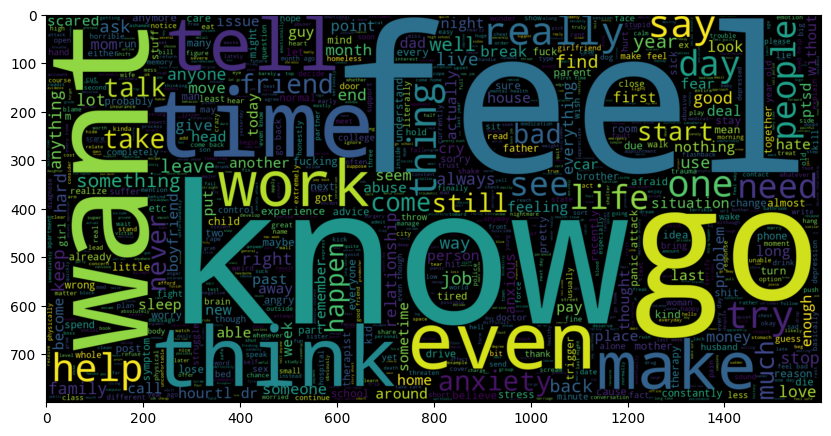

In [ ]:
from wordcloud import WordCloud, STOPWORDS

#wordcloud for stressed condition

plt.figure(figsize = (10,10)) # Text that is not Fake
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

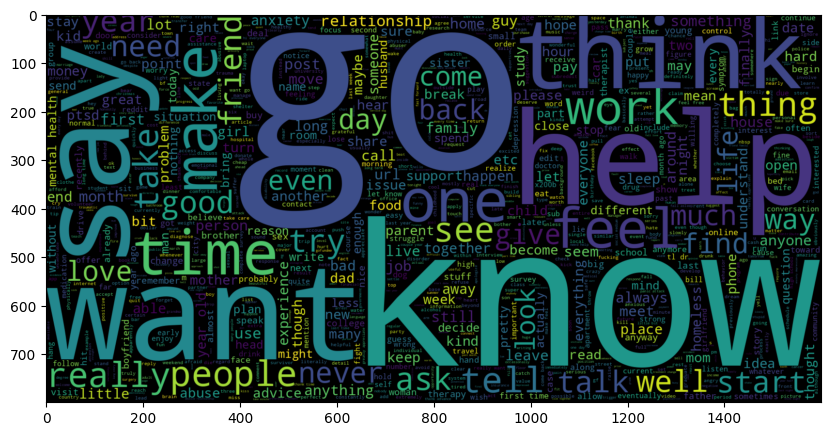

In [ ]:
#wordcloud for non-stressed condition

plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Unigram, Bigram and TRigram Analysis**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus,n,g):
  vec=CountVectorizer(ngram_range=(g,g)).fit(corpus) #countvectorizer converts text documents into a matrix of word counts to fit on n-grams of size g
  bag_of_words=vec.transform(corpus)  #transform the words in corpus into matrix
  sum_words=bag_of_words.sum(axis=0)  #flattens the matrix into one row after summing across axis=0 of the matrix
  words_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()] #create a dict 'vocubulary' with word, index pair to calculate frequency 
  words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True) #sort words in ascending order
  return words_freq[:n]

<Axes: >

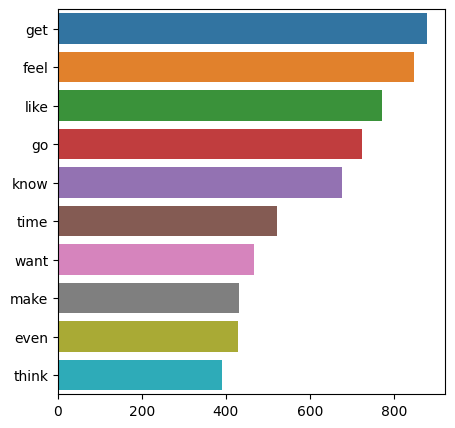

In [ ]:
import seaborn as sns

#UNIGRAM analysis on stressed condition (top 10 words)

plt.figure(figsize=(5,5))
most_common_uni=get_top_text_ngrams(df[df.label == 1].text,10,1)
most_common_uni=dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=(list(most_common_uni.keys())))

<Axes: >

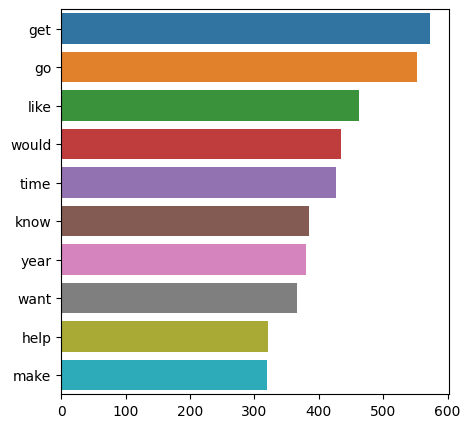

In [ ]:
#UNIGRAM analysis on non-stressed condition

plt.figure(figsize=(5,5))
most_common_uni=get_top_text_ngrams(df[df.label == 0].text,10,1)
most_common_uni=dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=(list(most_common_uni.keys())))

<Axes: >

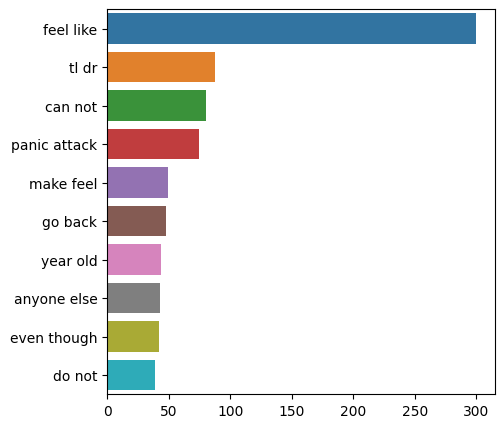

In [ ]:
#BIGRAM analysis on stressed condition

plt.figure(figsize=(5,5))
most_common_bi=get_top_text_ngrams(df[df.label == 1].text,10,2)
most_common_bi=dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

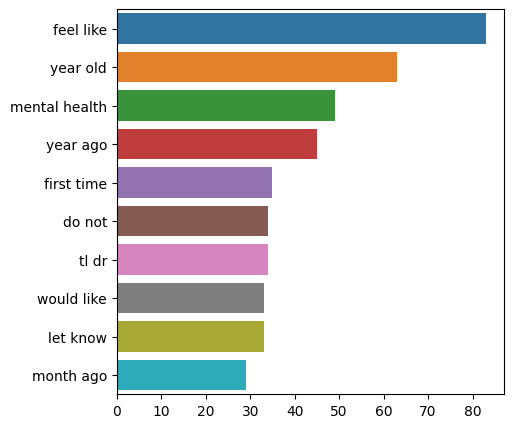

In [ ]:
#BIGRAM analysis on non-stressed condition

plt.figure(figsize=(5,5))
most_common_bi=get_top_text_ngrams(df[df.label == 0].text,10,2)
most_common_bi=dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

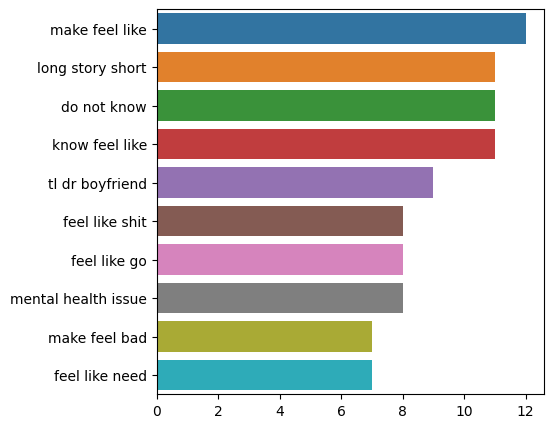

In [ ]:
#TRIGRAM analysis on stressed condition

plt.figure(figsize=(5,5))
most_common_tri=get_top_text_ngrams(df[df.label == 1].text,10,3)
most_common_tri=dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=(list(most_common_tri.keys())))

<Axes: >

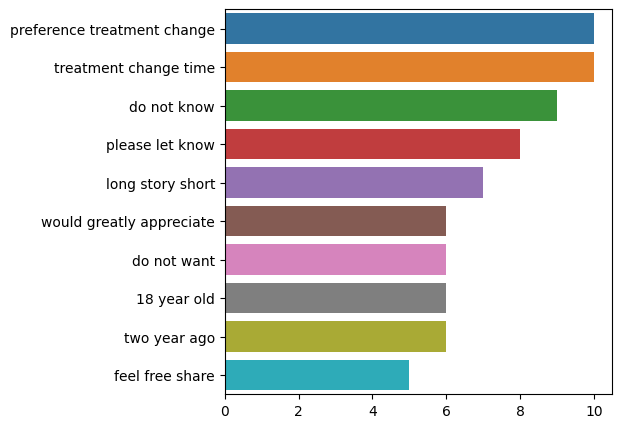

In [ ]:
#TRIGRAM analysis on non-stressed condition

plt.figure(figsize=(5,5))
most_common_tri=get_top_text_ngrams(df[df.label == 0].text,10,3)
most_common_tri=dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=(list(most_common_tri.keys())))

# Train-Test Split

In [ ]:
##split the data into train-test split

from sklearn.model_selection import train_test_split

#train-test split
x_train,x_test,y_train,y_test=train_test_split(df.text,df.label,test_size=0.2,random_state=42)

#train-validation split
x1_train, x1_val, y1_train, y1_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [ ]:
##size of train data

x1_train.shape,y1_train.shape

((1702,), (1702,))

In [ ]:
x1_val.shape,y1_val.shape

((568,), (568,))

In [ ]:
####size of test data

x_test.shape,y_test.shape

((568,), (568,))

In [ ]:
x1_train

2813    sean one thing describe sean good huge thirst ...
1342    30 year old male 5 lb dog recently homeless wa...
2470    love person dearly heart extremly tragic sudde...
1266    also want people feel away lot stress tension ...
1257    good chance seek treatment abroad specialise s...
                              ...                        
384     spend six year abusive relationship child toge...
1143    battle make year tension desperation resolutio...
2233    original url far 4 roll dark purple tulle 2 ro...
323     feel like pit can not escape know anxious time...
2753    even still say thing make feel uncomfortable e...
Name: text, Length: 1702, dtype: object

# Data Augmentation

In [ ]:
##preferred encoding UTF-8 for text attack library

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
print(locale.getpreferredencoding())

UTF-8


Download Textattack library for text data augmentation

In [ ]:
%%capture
!pip install textattack

In [ ]:
from textattack.augmentation import CharSwapAugmenter   ###augments words by swapping characters out for other characters
from textattack.augmentation import WordNetAugmenter    ###for replacing words with their synonyms
from textattack.augmentation import DeletionAugmenter   ###for deleting some parts of the text to make new text
#from textattack.augmentation import EasyDataAugmenter   ###for random swapping of positions, random removing, random replacing with synonyms of words
import numpy as np

##using GPU for faster computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


charswap_aug = CharSwapAugmenter()
wordnet_aug = WordNetAugmenter()
deletion_aug = DeletionAugmenter()
#eda_aug = EasyDataAugmenter()

augmented_data = [] ##new list for augmented data
augmented_labels = []   ###new list for augmented data labels same as original text labels

# character augmentation and labeling the augmented text
for text, label in zip(x1_train[:500], y1_train[:500]):
    augmented_char = charswap_aug.augment(text)
    augmented_data.append(augmented_char)
    augmented_labels.append(label)

# wordnet augmentation and labeling the augmented text
for text, label in zip(x1_train[500:1000], y1_train[500:1000]):
    augmented_word = wordnet_aug.augment(text)
    augmented_data.append(augmented_word)
    augmented_labels.append(label)

# deletion augmentation and labeling the augmented text
for text, label in zip(x1_train[1000:1700], y1_train[1000:1700]):
    augmented_del = deletion_aug.augment(text)
    augmented_data.append(augmented_del)
    augmented_labels.append(label)

#  easy data augmentation and labeling the augmented text
#for text, label in zip(x_train[2000:2800], y_train[2000:2800]):
    #augmented_eda = eda_aug.augment(text)
    #augmented_data.append(augmented_eda)
    #augmented_labels.append(label)



# Combine original and augmented data and labels
all_data = list(x1_train) + augmented_data
all_labels = list(y1_train) + augmented_labels

# Print the augmented data and labels
#for data, label in zip(augmented_data, augmented_labels):
    #print(data, label)



textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
##convert lists of augmented data and original data and labels into array and rename as x1_train and y1_train

x1_train= np.array(all_data)
y1_train = np.array(all_labels)

<ipython-input-43-b5ca73bfb835>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x1_train= np.array(all_data)


Check the new size of the data. See that training data has now increased to 3402 records from 1702 which means 1700 new records have been generated through text augmentation.

In [ ]:
x1_train.shape, y1_train.shape

((3402,), (3402,))

# Tokenisation

To pass this data into a model, all input sequences need to be of the same length. So assign maximum length of the sentence to 300 words. If the sequences are shorter than maxlen, they are padded with zeros at the beginning or end to match the desired length. If the sequences are longer than maxlen, they are truncated to the specified length.

In [ ]:
##assign maximum features to be extracted and max length of the sentence.

max_features=1000
maxlen=300

In [ ]:
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences

tokenizer=text.Tokenizer(num_words=max_features) #It specifies the maximum number of words to keep when tokenizing the text. 
                                                 ##The tokenizer will only keep the most common max_features words and discard the rest.

tokenizer.fit_on_texts(x1_train)                #convert the texts in x1_train in a form of word tokens

tokenized_train=tokenizer.texts_to_sequences(x1_train) #convert tokens in x1_train into a sequence of integers

x1_train=pad_sequences(tokenized_train,maxlen=maxlen)  ##pad sequences to the specified length

In [ ]:
type(x1_train)  ##checking the type of x_train now, it has changed to a sequence of integers

numpy.ndarray

In [ ]:
##tokenise the validation data

tokenized_test=tokenizer.texts_to_sequences(x1_val)
x1_val=pad_sequences(tokenized_test,maxlen=maxlen)

In [ ]:
##tokenise the test data

tokenized_test=tokenizer.texts_to_sequences(x_test)
x_test=pad_sequences(tokenized_test,maxlen=maxlen)

In [ ]:
type(x_test)

numpy.ndarray

# Build LSTM model

In [ ]:
import keras
from keras.regularizers import Regularizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM

embedding_dim = 128 # dimension for dense embeddings for each token

#sequential model(layers added one by one  in a sequence)
model = Sequential()

##################
###INPUT LAYER####
##################

#embedding layer to convert input integer sequences to dense vector representations
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, 
                    input_length=maxlen, trainable = False))

##################
###HIDDEN LAYER###
##################

##LSTM layer_1 for learning features and long term dependencies
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25,dropout=0.25))
#model.add(Dropout(0.25))

##LSTM layer_2 for learning features and long term dependencies
model.add(LSTM(units=64, recurrent_dropout=0.4, dropout=0.4) )
model.add(Dropout(0.2))

#fully connected dense layer for higher level feature learning
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))

##################
###OUTPUT LAYER###
##################

###the classification layer
model.add(Dense(1, activation="sigmoid"))  

#model compilation
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.0005),
              metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 128)          128000    
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          131584    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Model training

In [ ]:
# ## Model training
history = model.fit(x1_train, y1_train,
                   epochs=15, validation_data=(x1_val,y1_val),
                   batch_size=64
                   )

Epoch 1/15
54/54 [==============================] - 113s 2s/step - loss: 0.6931 - accuracy: 0.5159 - val_loss: 0.6926 - val_accuracy: 0.4982
Epoch 2/15
54/54 [==============================] - 106s 2s/step - loss: 0.6923 - accuracy: 0.5232 - val_loss: 0.6928 - val_accuracy: 0.4982
Epoch 3/15
54/54 [==============================] - 106s 2s/step - loss: 0.6904 - accuracy: 0.5332 - val_loss: 0.6891 - val_accuracy: 0.4982
Epoch 4/15
54/54 [==============================] - 105s 2s/step - loss: 0.6878 - accuracy: 0.5317 - val_loss: 0.6919 - val_accuracy: 0.5070
Epoch 5/15
54/54 [==============================] - 106s 2s/step - loss: 0.6778 - accuracy: 0.5561 - val_loss: 0.6618 - val_accuracy: 0.6144
Epoch 6/15
54/54 [==============================] - 107s 2s/step - loss: 0.6666 - accuracy: 0.5788 - val_loss: 0.6627 - val_accuracy: 0.5757
Epoch 7/15
54/54 [==============================] - 106s 2s/step - loss: 0.6651 - accuracy: 0.5832 - val_loss: 0.6475 - val_accuracy: 0.6391
Epoch 8/15
54

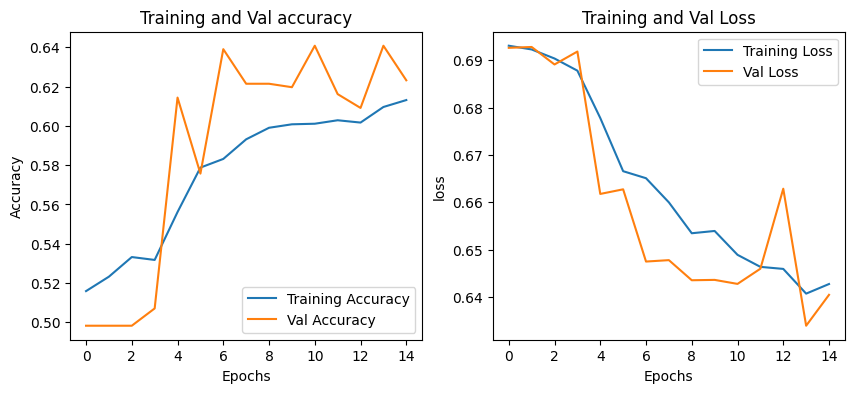

In [ ]:
epochs=[i for i in range(15)]
fig,ax=plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(10,4)

ax[0].plot(epochs,train_acc,label="Training Accuracy")
ax[0].plot(epochs,val_acc,label="Val Accuracy")
ax[0].set_title('Training and Val accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs,train_loss,label="Training Loss")
ax[1].plot(epochs,val_loss,label="Val Loss")
ax[1].set_title("Training and Val Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
plt.show()

# Model Evaluation

In [ ]:
# Import sklearn
from sklearn.metrics import f1_score

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Get the predictions from the model
y_pred = model.predict(x_test)
# Convert the predictions to binary values
y_pred = (y_pred > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the test accuracy and F1 score
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('F1 Score:', f1)

18/18 [==============================] - 3s 161ms/step
Test Loss: 0.661317765712738
Test Accuracy: 0.6038732528686523
F1 Score: 0.5945945945945946


Test Loss: 0.661317765712738
Test Accuracy: 0.6038732528686523
Confusion Matrix:
[[178  85]
 [140 165]]


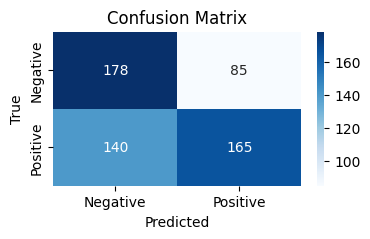

In [ ]:
# Import the necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the test accuracy and confusion matrix
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model Training with CNN

In [ ]:
from keras import layers

embedding_dim = 100

#####################
###Input Layer######
#####################

model = Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=embedding_dim, 
                           input_length=maxlen))
###########################
###Feature extraction layer
###########################

#convolutional layer
model.add(layers.Conv1D(128, 5, activation='relu')) # Add a 1D convolutional layer with 128 filters, filter size 5, and ReLU activation
model.add(layers.Dropout(0.6))                      #dropouts to prevent overfitting
model.add(layers.GlobalMaxPooling1D())

#dense fully connected layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.6))

#####################
#####Output Layer####
#####################

model.add(layers.Dense(1, activation='sigmoid'))

###model compilation
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 100)          100000    
                                                                 
 conv1d_1 (Conv1D)           (None, 296, 128)          64128     
                                                                 
 dropout_6 (Dropout)         (None, 296, 128)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# ## Model training
history = model.fit(x1_train, y1_train,
                   epochs=10, validation_data=(x1_val,y1_val),
                   batch_size=256
                   )

Epoch 1/10
14/14 [==============================] - 1s 23ms/step - loss: 0.6934 - accuracy: 0.5135 - val_loss: 0.6927 - val_accuracy: 0.4982
Epoch 2/10
14/14 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.5203 - val_loss: 0.6922 - val_accuracy: 0.4982
Epoch 3/10
14/14 [==============================] - 0s 10ms/step - loss: 0.6878 - accuracy: 0.5306 - val_loss: 0.6909 - val_accuracy: 0.4982
Epoch 4/10
14/14 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.5423 - val_loss: 0.6886 - val_accuracy: 0.5088
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 0.6828 - accuracy: 0.5570 - val_loss: 0.6853 - val_accuracy: 0.5387
Epoch 6/10
14/14 [==============================] - 0s 10ms/step - loss: 0.6748 - accuracy: 0.5655 - val_loss: 0.6805 - val_accuracy: 0.5493
Epoch 7/10
14/14 [==============================] - 0s 11ms/step - loss: 0.6640 - accuracy: 0.5917 - val_loss: 0.6710 - val_accuracy: 0.6408
Epoch 8/10
14

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Get the predictions from the model
y_pred = model.predict(x_test)
# Convert the predictions to binary values if needed
y_pred = (y_pred > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the test accuracy and F1 score
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('F1 Score:', f1)

18/18 [==============================] - 0s 2ms/step
Test Loss: 0.6228991150856018
Test Accuracy: 0.6795774698257446
F1 Score: 0.7385057471264368


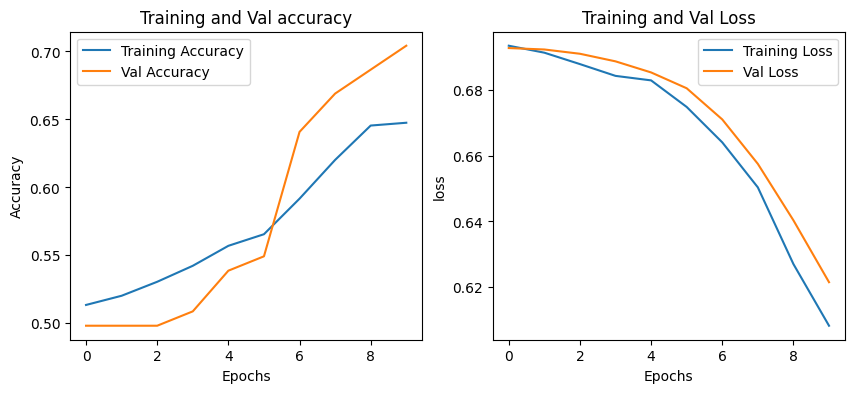

In [ ]:
epochs=[i for i in range(10)]
fig,ax=plt.subplots(1,2)
train_acc=history.history['accuracy']
train_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(10,4)

ax[0].plot(epochs,train_acc,label="Training Accuracy")
ax[0].plot(epochs,val_acc,label="Val Accuracy")
ax[0].set_title('Training and Val accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs,train_loss,label="Training Loss")
ax[1].plot(epochs,val_loss,label="Val Loss")
ax[1].set_title("Training and Val Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
plt.show()

Test Loss: 0.6228991150856018
Test Accuracy: 0.6795774698257446
Confusion Matrix:
[[129 134]
 [ 48 257]]


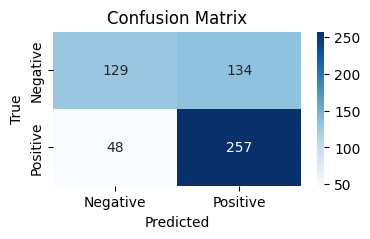

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the test accuracy and confusion matrix
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()